<a href="https://colab.research.google.com/github/diegosdantonio/LIDAR-DTR/blob/main/Particle_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pickle

# Generate mock polar LiDAR data
def generate_mock_lidar_data(num_samples, num_points):
    samples = []
    for _ in range(num_samples):
        # Generate random angles and distances for LiDAR points
        angles = np.random.uniform(0, 360, num_points)
        distances = np.random.uniform(0, 10, num_points)  # Distance up to 10 units
        sample = np.vstack((angles, distances)).T
        samples.append(sample)
    return samples

# Save the mock data to a file
def save_mock_data(filename, num_samples=10, num_points=360):
    data = generate_mock_lidar_data(num_samples, num_points)
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"Mock data saved to {filename}")

# Generate and save mock data
save_mock_data("samples.dat")


Mock data saved to samples.dat


Loading data...
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles
Plotting LiDAR data...
Plotting random particles


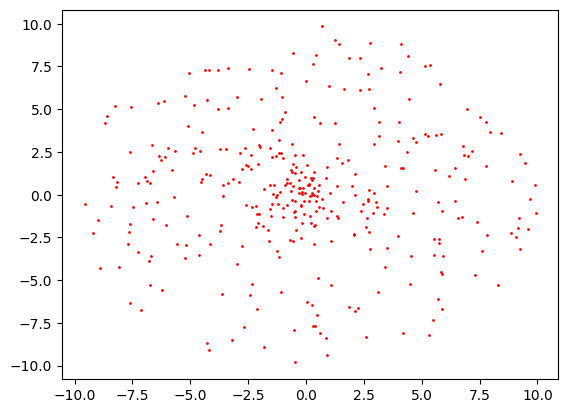

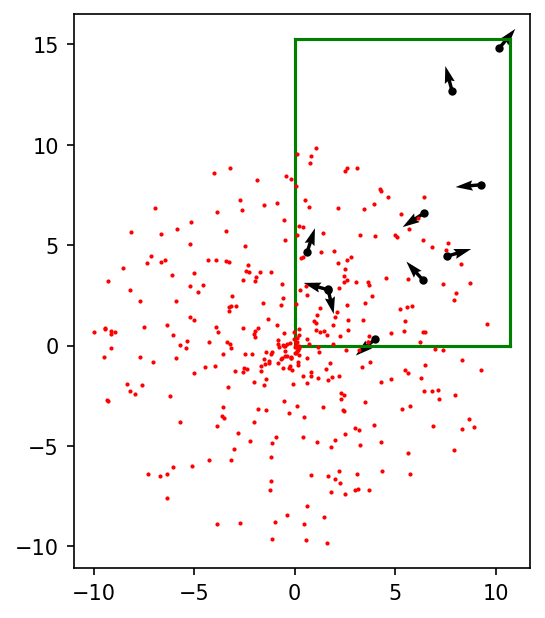

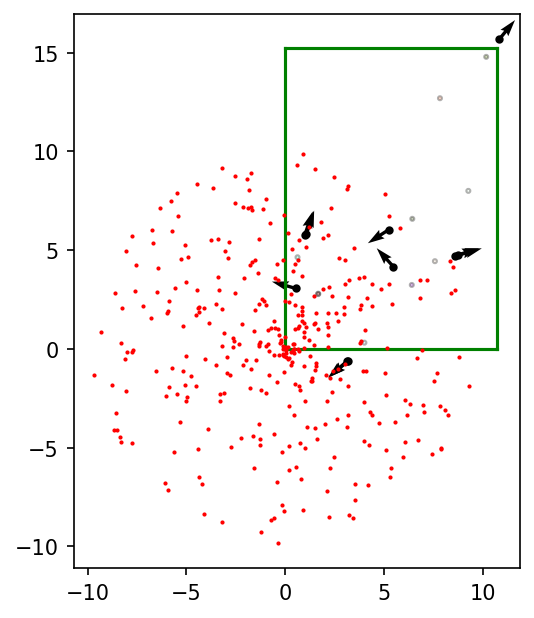

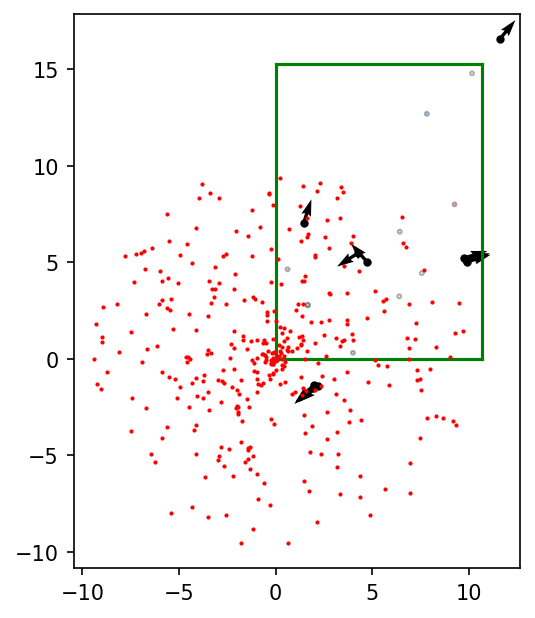

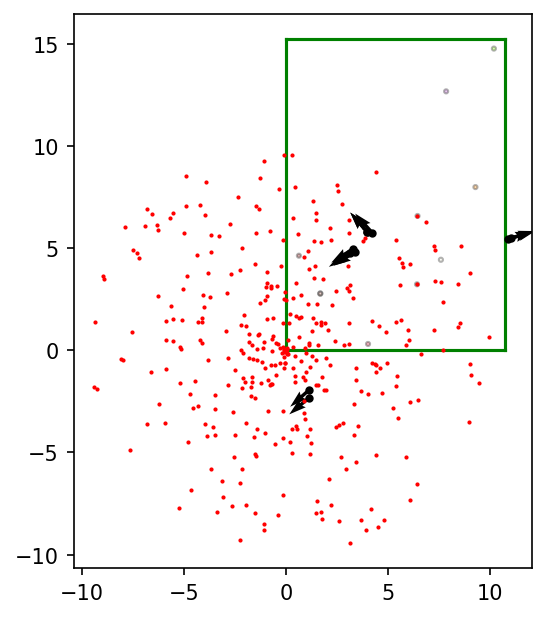

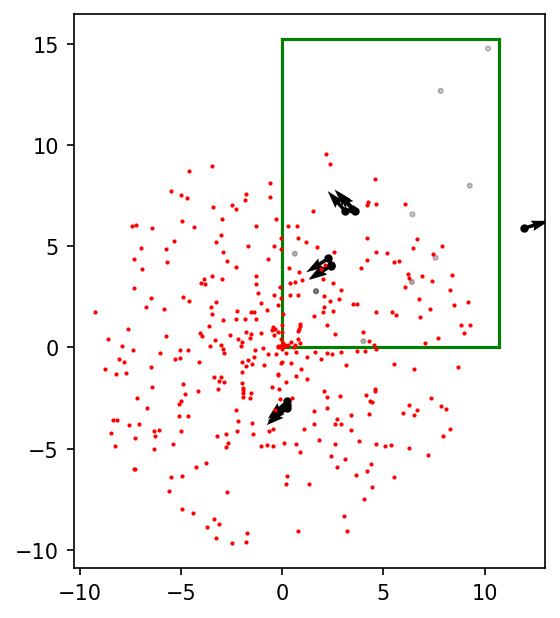

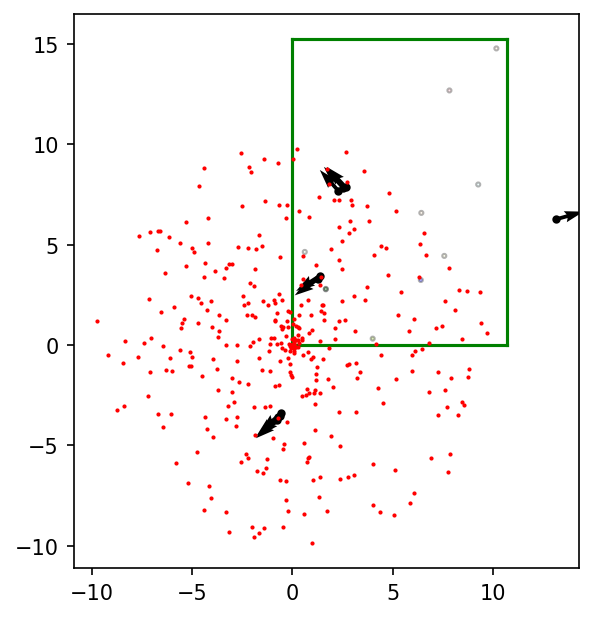

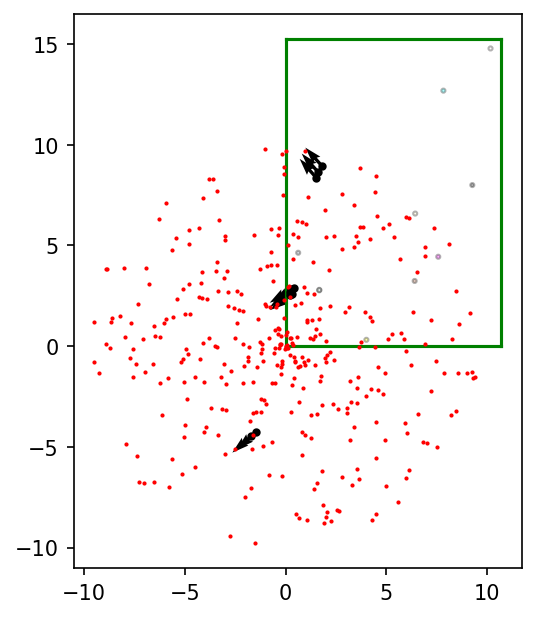

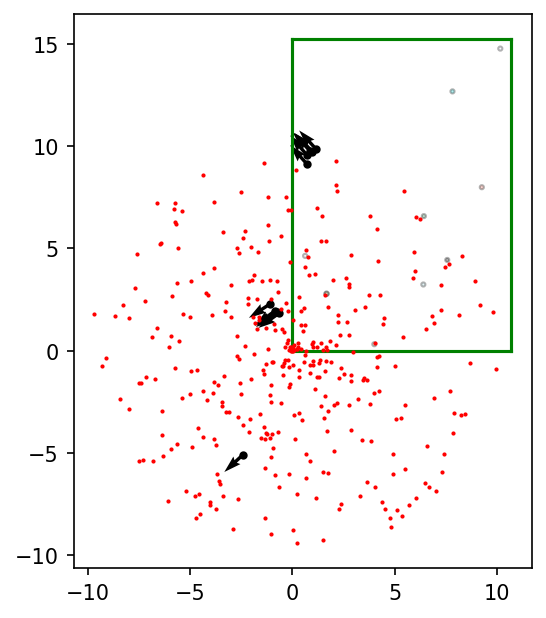

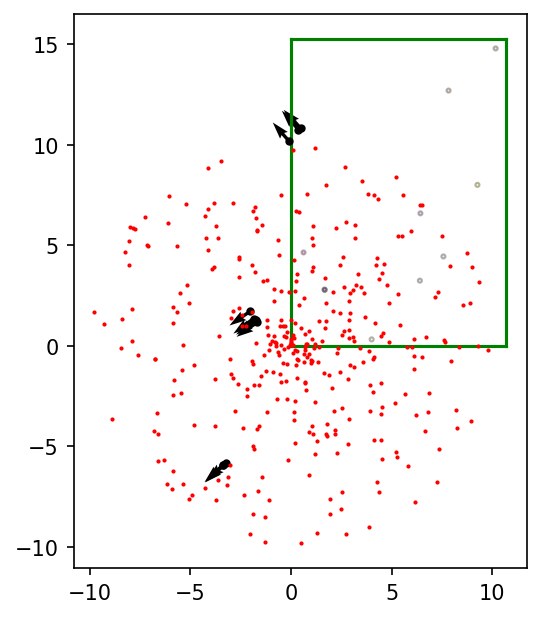

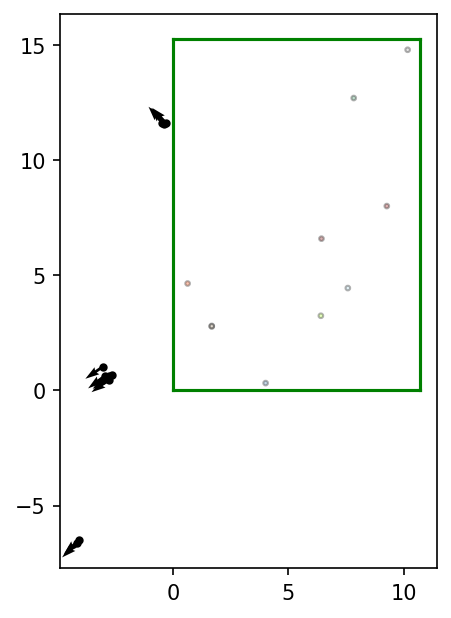

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import random
from matplotlib.colors import CSS4_COLORS


def draw_env(w, h):
    plt.plot((0, w), (0, 0), 'g')
    plt.plot((0, 0), (h, 0), 'g')
    plt.plot((w, w), (h, 0), 'g')
    plt.plot((0, w), (h, h), 'g')
    plt.grid()


def draw_particles(p, color="k"):
    xs, ys, thetas = p.T
    plt.plot(xs, ys, '.', color=color)
    plt.quiver(xs, ys, np.cos(thetas), np.sin(thetas), color=color)


# Generate random particles
def gen_particles_random(w, h, n):
    xs = np.random.uniform(0, w, n)
    ys = np.random.uniform(0, h, n)
    thetas = np.random.uniform(0, 2 * np.pi, n)
    particles = np.vstack((xs, ys, thetas)).T
    return particles


# Convert polar to cartesian coordinates and plot the points
def draw_points_one_trial(position_polar):
    position_cartesian = np.array([[polar[1] * np.cos(polar[0] * np.pi / 180),
                                    polar[1] * np.sin(polar[0] * np.pi / 180),
                                    polar[0] * np.pi / 180]
                                   for polar in position_polar])
    plt.plot(position_cartesian[:, 0], position_cartesian[:, 1], 'ro', markersize=1)
    return position_cartesian


# Move particles
def move_particle(particles, d, sigma_u):
    # Vectorize the movement of particles
    x, y, theta = particles.T
    delta_x = d * np.cos(theta)
    delta_y = d * np.sin(theta)

    x_new = x + np.random.normal(delta_x, sigma_u[0], size=len(x))
    y_new = y + np.random.normal(delta_y, sigma_u[1], size=len(y))
    theta_new = theta + np.random.normal(0, sigma_u[2], size=len(theta))

    return np.vstack((x_new, y_new, theta_new)).T


# Calculate distance to the map boundary
def distance_to_map(poly, px, py):
    return poly.boundary.distance(Point(px, py))


# Particle resampling
def resample_particles(particles, weights):
    indices = np.random.choice(len(particles), size=len(particles), replace=True, p=weights)
    return particles[indices]


if __name__ == "__main__":
    np.random.seed(42)  # Set a seed for reproducibility
    num_samples = 10
    d = 1.2
    w = 10.7
    h = 15.24
    num_particles = 10
    sigma_u = [0.1, 0.1, 0.01]

    # Create polygon representing the map
    poly = Polygon([[0, 0], [w, 0], [w, h], [0, h], [0, 0]])

    print("Loading data...")
    with open("samples.dat", "rb") as f:
        positions = pickle.load(f)

    particles = gen_particles_random(w, h, num_particles)
    new_particles = np.copy(particles)

    for index in range(num_samples):
        position_polar = np.array(positions[index])
        print("Plotting LiDAR data...")
        position_cart = draw_points_one_trial(position_polar)

        fig = plt.figure(frameon=True, dpi=150)
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.grid()
        draw_env(w, h)
        print("Plotting random particles")
        draw_particles(new_particles)

        errors = np.zeros(num_particles)

        for i in range(num_particles):
            x, y, theta = new_particles[i]
            spx = x + np.cos(theta) * position_cart[:, 0] - np.sin(theta) * position_cart[:, 1]
            spy = y + np.sin(theta) * position_cart[:, 0] + np.cos(theta) * position_cart[:, 1]
            # Fixing the deprecation warning by using np.fromiter
            errors[i] = np.sum(np.fromiter((distance_to_map(poly, spx[j], spy[j]) ** 6 for j in range(spx.shape[0])), dtype=float))

        # Avoid division by zero: if the sum of weights is zero, assign equal weights
        weights = np.exp(-errors)  # Apply exponential scaling to weights for numerical stability
        total_weight = np.sum(weights)
        if total_weight == 0:
            weights = np.ones(num_particles) / num_particles  # Assign equal weights if total weight is zero
        else:
            weights /= total_weight  # Normalize weights

        # Plot circles representing the particle weights
        colors = list(CSS4_COLORS.values())
        for i in range(num_particles):
            x, y, theta = particles[i]
            color = random.choice(colors)
            circle = plt.Circle((x, y), weights[i], alpha=0.3, ec="black", fc=color)
            ax.add_artist(circle)

        # Resample particles based on weights
        new_particles = resample_particles(new_particles, weights)
        new_particles = move_particle(new_particles, d, sigma_u)

    plt.show()
